In [1]:
import pandas as pd
from tqdm import tqdm

In [337]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [3]:
# method
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# model
# from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# from sklearn import tree
from sklearn.utils import resample
from sklearn.decomposition import PCA
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score

In [506]:
# matplotlib 한글 폰트 셋업
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
fm.fontManager.addfont(fontpath)  # 에전의 rebuild 대신 이걸 추가해야 설치한 폰트 추가됨
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic')
plt.rc('axes', unicode_minus=False)  # Glyph 8722 방지용

In [4]:
years = ["2017", "2018", "2019", "2020", "2021", "2022", "2023"]

In [5]:
dfs = []
for year in tqdm(years):
    df = pd.read_csv(f"bow_{year}.csv", low_memory=False)
    
    # 월별로 합치기
    df["ym"] = df["date"].astype(str).str[:6]
    grp = df.drop("date", axis=1).groupby("ym")
    df_sum = grp.sum()
    dfs.append(df_sum)

100%|██████████| 7/7 [00:26<00:00,  3.74s/it]


In [6]:
[len(d.columns) for d in dfs]

[66763, 70259, 73326, 73574, 78883, 70355, 51928]

In [7]:
bow_raw = pd.concat(dfs)
bow_raw

,것,등,수,시장,투자,경제,기업,올해,전망,미국,...,보탤지,스피룰리나,게임광,죠슈,글쎼잇단,공을기,우웨,증열,트파이낸싱,물량만해
ym,,,,,,,,,,,,,,,,,,,,,
201701,22577,19187,14866,7556,10896,5550,6004.0,5616,4229,8211,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201702,19682,18080,14695,6306,8818,3425,4848.0,3117,2586,5783,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201703,20141,21085,16619,6376,11138,4650,3490.0,3011,2168,5208,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201704,17224,17744,13772,6744,9859,4197,4846.0,3394,2402,4306,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201705,20873,17963,13378,6405,10833,4629,6162.0,3350,2310,4241,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202301,27790,22676,17200,13025,9608,6201,8867.0,8273,5419,5928,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
202302,20750,17738,13423,8996,6709,4217,5569.0,4542,3485,4985,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
202303,24031,21681,15370,9829,8940,4208,8547.0,5599,3489,8544,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
bow_raw = bow_raw.fillna(0)
# for col in tqdm(bow.columns):  # 굳이 astype 하진 않아도 될 듯
    # bow[col] = bow[col].astype(int)
bow_raw

,것,등,수,시장,투자,경제,기업,올해,전망,미국,...,보탤지,스피룰리나,게임광,죠슈,글쎼잇단,공을기,우웨,증열,트파이낸싱,물량만해
ym,,,,,,,,,,,,,,,,,,,,,
201701,22577,19187,14866,7556,10896,5550,6004.0,5616,4229,8211,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
201702,19682,18080,14695,6306,8818,3425,4848.0,3117,2586,5783,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
201703,20141,21085,16619,6376,11138,4650,3490.0,3011,2168,5208,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
201704,17224,17744,13772,6744,9859,4197,4846.0,3394,2402,4306,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
201705,20873,17963,13378,6405,10833,4629,6162.0,3350,2310,4241,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202301,27790,22676,17200,13025,9608,6201,8867.0,8273,5419,5928,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
202302,20750,17738,13423,8996,6709,4217,5569.0,4542,3485,4985,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
202303,24031,21681,15370,9829,8940,4208,8547.0,5599,3489,8544,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
ratios = []
for ym in tqdm(bow_raw.index):
    values = bow_raw.loc[ym, :].values
    # ratio = (values / values.sum()) * 100
    ratio = (values / values.sum()) * 10000
    ratios.append(ratio)

bow = pd.DataFrame(ratios, index=bow_raw.index, columns=bow_raw.columns)

100%|██████████| 77/77 [00:22<00:00,  3.47it/s]


In [11]:
bow

,것,등,수,시장,투자,경제,기업,올해,전망,미국,...,보탤지,스피룰리나,게임광,죠슈,글쎼잇단,공을기,우웨,증열,트파이낸싱,물량만해
ym,,,,,,,,,,,,,,,,,,,,,
201701,84.715617,71.995329,55.781652,28.352359,40.885032,20.825250,22.528793,21.072902,15.868465,30.810113,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
201702,82.391178,75.685016,61.515006,26.397661,36.913190,14.337455,20.294301,13.048130,10.825302,24.208321,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
201703,68.536595,71.748876,56.551794,21.696506,37.900829,15.823205,11.875911,10.245950,7.377357,17.721989,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
201704,66.525304,68.533732,53.192434,26.047762,38.079016,16.210329,18.717001,13.108853,9.277391,16.631326,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
201705,78.280785,67.367305,50.172009,24.020909,40.627401,17.360310,23.109577,12.563629,8.663279,15.905179,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202301,126.008430,102.819977,77.990104,59.059367,43.565635,28.117246,40.205713,37.512333,24.571417,26.879380,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
202302,125.056426,106.903657,80.897947,54.217234,40.433907,25.415082,33.563337,27.373797,21.003453,30.043676,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
202303,121.068767,109.229409,77.434436,49.518743,45.039939,21.200007,43.059995,28.207899,17.577667,43.044881,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### 모델

In [381]:
target = pd.read_csv("./SDC/DATA/merged_datas.csv")[["date", "기성총액"]]
target

,date,기성총액
0,1960-01,NaN
1,1960-04,NaN
2,1960-07,NaN
3,1960-10,NaN
4,1961-01,NaN
...,...,...
722,2023-01,13915617.0
723,2023-02,15060518.0
724,2023-03,14519456.0
725,2023-04,14859560.0


In [382]:
target["ym"] = target["date"].str.replace("-", "")
target = target.drop("date", axis=1).set_index("ym")
target["yoy"] = target["기성총액"].pct_change(12)
target["yoy_bin"] = target["yoy"].dropna().apply(lambda x: 0 if x < 0 else 1)
target

,기성총액,yoy,yoy_bin
ym,,,
196001,NaN,NaN,NaN
196004,NaN,NaN,NaN
196007,NaN,NaN,NaN
196010,NaN,NaN,NaN
196101,NaN,NaN,NaN
...,...,...,...
202301,13915617.0,0.103287,1.0
202302,15060518.0,0.228275,1.0
202303,14519456.0,0.159867,1.0


In [383]:
target = target.dropna()
target

,기성총액,yoy,yoy_bin
ym,,,
199807,3857138.0,-0.140519,0.0
199808,3692541.0,-0.233118,0.0
199809,3797432.0,-0.209151,0.0
199810,4091186.0,-0.156918,0.0
199811,3969769.0,-0.158606,0.0
...,...,...,...
202212,13480133.0,0.047968,1.0
202301,13915617.0,0.103287,1.0
202302,15060518.0,0.228275,1.0


In [384]:
# hp필터
bin_func = lambda x: 0 if x < 0 else 1
cycle, trend = sm.tsa.filters.hpfilter(target["yoy"], 14400)
target["yoy_hp"] = trend
target["yoy_hp_bin"] = target["yoy_hp"].dropna().apply(bin_func)
target["yoy_hp_diff"] = trend.diff(1)
target["yoy_hp_diff_bin"] = target["yoy_hp_diff"].dropna().apply(bin_func)
# target["yoy_hp_diff_bin"] = 
# cycle
#.plot()
target

/tmp/ipykernel_30370/1535745234.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target["yoy_hp"] = trend
/tmp/ipykernel_30370/1535745234.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target["yoy_hp_bin"] = target["yoy_hp"].dropna().apply(bin_func)
/tmp/ipykernel_30370/1535745234.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

,기성총액,yoy,yoy_bin,yoy_hp,yoy_hp_bin,yoy_hp_diff,yoy_hp_diff_bin
ym,,,,,,,
199807,3857138.0,-0.140519,0.0,-0.118824,0,NaN,NaN
199808,3692541.0,-0.233118,0.0,-0.112005,0,0.006818,1.0
199809,3797432.0,-0.209151,0.0,-0.105189,0,0.006817,1.0
199810,4091186.0,-0.156918,0.0,-0.098383,0,0.006805,1.0
199811,3969769.0,-0.158606,0.0,-0.091607,0,0.006777,1.0
...,...,...,...,...,...,...,...
202212,13480133.0,0.047968,1.0,0.137904,1,0.006106,1.0
202301,13915617.0,0.103287,1.0,0.144021,1,0.006117,1.0
202302,15060518.0,0.228275,1.0,0.150146,1,0.006125,1.0


<Axes: xlabel='ym'>

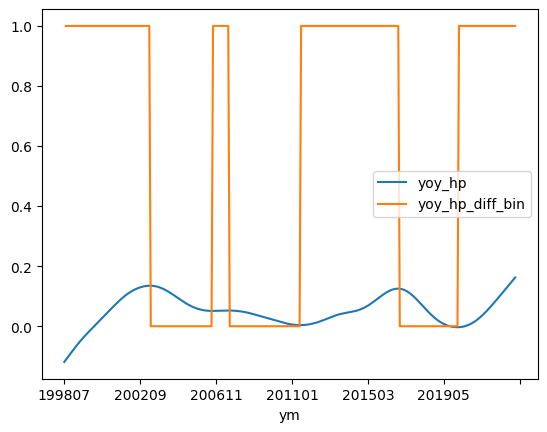

In [385]:
target[["yoy_hp", "yoy_hp_diff_bin"]].plot()

In [386]:
# 잠시 교체 >> 안함
# target["yoy_bin"] = target["yoy_hp_diff_bin"]

In [387]:
# 병합
data = pd.merge(bow, target[["yoy_bin"]], how="left", left_index=True, right_index=True)
data

,것,등,수,시장,투자,경제,기업,올해,전망,미국,...,스피룰리나,게임광,죠슈,글쎼잇단,공을기,우웨,증열,트파이낸싱,물량만해,yoy_bin
ym,,,,,,,,,,,,,,,,,,,,,
201701,84.715617,71.995329,55.781652,28.352359,40.885032,20.825250,22.528793,21.072902,15.868465,30.810113,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
201702,82.391178,75.685016,61.515006,26.397661,36.913190,14.337455,20.294301,13.048130,10.825302,24.208321,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
201703,68.536595,71.748876,56.551794,21.696506,37.900829,15.823205,11.875911,10.245950,7.377357,17.721989,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
201704,66.525304,68.533732,53.192434,26.047762,38.079016,16.210329,18.717001,13.108853,9.277391,16.631326,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
201705,78.280785,67.367305,50.172009,24.020909,40.627401,17.360310,23.109577,12.563629,8.663279,15.905179,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202301,126.008430,102.819977,77.990104,59.059367,43.565635,28.117246,40.205713,37.512333,24.571417,26.879380,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
202302,125.056426,106.903657,80.897947,54.217234,40.433907,25.415082,33.563337,27.373797,21.003453,30.043676,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
202303,121.068767,109.229409,77.434436,49.518743,45.039939,21.200007,43.059995,28.207899,17.577667,43.044881,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0


In [388]:
# temp["yoy_bin"].shift(-1)
data.tail(3)

,것,등,수,시장,투자,경제,기업,올해,전망,미국,...,스피룰리나,게임광,죠슈,글쎼잇단,공을기,우웨,증열,트파이낸싱,물량만해,yoy_bin
ym,,,,,,,,,,,,,,,,,,,,,
202303,121.068767,109.229409,77.434436,49.518743,45.039939,21.200007,43.059995,28.207899,17.577667,43.044881,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
202304,118.578963,108.226452,79.264892,46.636708,46.833039,19.574788,35.886227,26.722319,18.502924,37.637293,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
202305,114.806792,104.910937,76.908114,46.449929,42.586187,22.114205,34.826817,27.896530,17.463898,32.079150,...,0.005315,0.005315,0.005315,0.005315,0.005315,0.005315,0.005315,0.005315,0.005315,NaN


In [389]:
temp = data.copy()
temp["yoy_bin"] = temp["yoy_bin"].shift(-12)
temp.tail(20)

,것,등,수,시장,투자,경제,기업,올해,전망,미국,...,스피룰리나,게임광,죠슈,글쎼잇단,공을기,우웨,증열,트파이낸싱,물량만해,yoy_bin
ym,,,,,,,,,,,,,,,,,,,,,
202110,124.961166,108.562047,78.956449,42.523512,41.099103,23.429068,32.497394,25.387630,18.947092,24.221088,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
202111,119.538961,106.922157,77.758303,38.620043,43.530283,18.409554,33.135145,32.775984,18.866201,28.409616,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
202112,109.895266,118.140706,70.460553,48.028106,36.972679,22.727680,37.958547,37.220464,19.675180,16.116566,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
202201,121.133666,108.436852,76.652609,46.308365,40.796647,20.954461,40.945612,32.082173,22.051839,24.822595,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
202202,112.604197,110.624783,75.536518,48.758826,39.336222,17.570080,34.354326,22.173886,18.192817,23.196954,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
202203,115.616306,115.947111,73.212634,47.222397,32.209369,22.571920,33.753125,28.173549,17.179800,19.942021,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
202204,123.217349,108.879972,79.608083,45.869855,33.866187,25.877959,33.671203,21.472552,19.199776,19.589743,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
202205,115.255699,117.958195,74.833920,46.941420,58.277185,22.445444,35.658234,24.906083,16.840655,34.243892,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
202206,114.832174,117.170647,75.288328,44.247067,38.450806,24.751031,33.174790,24.787816,18.613196,22.517658,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN


In [390]:
# 데이터 나누기
temp = data.copy()
temp["yoy_bin"] = temp["yoy_bin"].shift(-1)
temp = temp.dropna()
X = temp.drop("yoy_bin", axis=1)
y = temp["yoy_bin"]

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [391]:
# # 기간 나눠서 쓰기
# temp = data.copy()
# temp["yoy_bin"] = temp["yoy_bin"].shift(-12)
# temp = temp.dropna()
# X = temp.drop("yoy_bin", axis=1)
# y = temp["yoy_bin"]



# # 훈련, 평가 시 사용할
# split_date = "202101"  # 12개월 + 해야 함
# X_train = X.loc[:split_date].iloc[:-1]
# y_train = y.loc[:split_date].iloc[:-1]

# # # predict 만들 때 사용할
# X_test = X.loc[split_date:]
# y_test = y.loc[split_date:]

# # train_test_split
# # X_train, X_test, y_train, y_test = train_test_split(X_run, y_run, test_size=0.2, random_state=0)

In [392]:
len(X_train), len(X_test), temp.isna().sum().sum(), y_train.mean(), y_test.mean()

(60, 15, 0, 0.7, 0.7333333333333333)

In [393]:
# model fit
# model = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=0)
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [394]:
# lgbm fit
model = LGBMClassifier(n_estimators=100, verbose=-1)
model.fit(X_train * 100, y_train)

LGBMClassifier(verbose=-1)

In [395]:
# predict
y_pred = model.predict(X_test * 100)
y_pred_proba = model.predict_proba(X_test * 100)

acc = accuracy_score(y_test, y_pred)

vc = y_test.value_counts()
if len(vc.index) == 2:  # 0과 1 모두 y에 존재하는 경우
    auc = roc_auc_score(y_test, y_pred_proba[:, 1])
else:  # else: ROC_AUC 계산 불가함
    auc = None

acc, auc

(0.4, 0.5454545454545454)

In [364]:
from sklearn.model_selection import cross_val_score

k = 3
model = RandomForestClassifier(n_estimators=100, random_state=0)
scores = cross_val_score(model, X, y, cv=k,
                         # scoring='neg_mean_absolute_error')
                         # scoring='accuracy')
                         scoring='roc_auc')

In [365]:
print(scores.mean())
scores

0.9561965811965812


array([1.        , 1.        , 0.86858974])

In [ ]:
imp = pd.Series(model.feature_importances_, X.columns).sort_values(ascending=False)

In [ ]:
imp.head(20)

In [ ]:
# time_lag여러개 돌리기

fimps = {}
rows = []
models = {}
for lag in tqdm(range(0, 12+1)):
    # lag 준비 (몇 개월 후의 기성액 yoy를 예측할 것인지)
    lag = lag * -1
    
    # 데이터 나누기
    temp = data.copy()
    temp["yoy_bin"] = temp["yoy_bin"].shift(lag)
    temp = temp.dropna()
    X = temp.drop("yoy_bin", axis=1)
    y = temp["yoy_bin"]
    
    # # pca로 X를 차원축소
    # pca = PCA(n_components=50).fit(X)
    # X = pca.transform(X)

    # train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    # model fit
    model = RandomForestClassifier(n_estimators=100, random_state=0)
    # model = LGBMClassifier(n_estimators=100, verbose=-1)
    # model = RandomForestClassifier(n_estimators=100)
    model.fit(X_train, y_train)
    models[lag] = model
    
    # predict
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    acc = accuracy_score(y_test, y_pred)
    vc = y_test.value_counts()
    if len(vc.index) == 2:  # 0과 1 모두 y에 존재하는 경우
        auc = roc_auc_score(y_test, y_pred_proba[:, 1])
    else:  # else: ROC_AUC 계산 불가함
        auc = None
    
    # predict - bootstrap
    bootstrap_idx = resample(X_test.index, replace=True, n_samples=50, random_state=0)
    bt_X = X_test.loc[bootstrap_idx, :]
    bt_y = y_test.loc[bootstrap_idx]
    y_pred_bt = model.predict(bt_X)
    y_pred_proba_bt = model.predict_proba(bt_X)
    
    acc_bt = accuracy_score(bt_y, y_pred_bt)
    vc = y_test.value_counts()
    if len(vc.index) == 2:  # 0과 1 모두 y에 존재하는 경우
        auc_bt = roc_auc_score(bt_y, y_pred_proba_bt[:, 1])
    else:  # else: ROC_AUC 계산 불가함
        auc_bt = None
    
    # save
    row = {}
    row["lag"] = lag
    row["acc"] = acc
    row["auc"] = auc
    row["acc_bt"] = acc_bt
    row["auc_bt"] = auc_bt
    row["train_n"] = len(X_train)
    row["test_n"] = len(X_test)
    row["train_true"] = y_train.mean()
    row["test_true"] = y_test.mean()
    rows.append(row)
    
    # # imp
    # imp = pd.Series(model.feature_importances_, X.columns).sort_values(ascending=False)
    # fimps[lag] = imp

In [ ]:
result = pd.DataFrame(rows)
# result.to_csv("result_lag_ratio.csv")
result

In [ ]:
# 그래프
temp = result.set_index("lag")
temp.index = temp.index * -1
temp[["acc", "auc"]].plot.bar(figsize=(10, 5))
# temp["train_true"].plot.bar(alpha=0.3, color="gray")
# temp["test_true"].plot.bar(alpha=0.2, color="green")
plt.grid()
# plt.savefig("./result_lag_ratio.png")
plt.show()

In [ ]:
# # pca로 X를 차원축소
# pca = PCA(n_components=100).fit(X)
# X_pca = pca.transform(X)

In [174]:
# corss_val_socre로 변경

# fimps = {}
rows = []
# models = {}
# for lag in tqdm(range(0, 3+1)):
for lag in tqdm(range(0, 24+1)):
    # lag 준비 (몇 개월 후의 기성액 yoy를 예측할 것인지)
    lag = lag * -1
    
    # 데이터 나누기
    temp = data.copy()
    temp["yoy_bin"] = temp["yoy_bin"].shift(lag)
    temp = temp.dropna()
    X = temp.drop("yoy_bin", axis=1)
    y = temp["yoy_bin"]
    
    # 부트스트래핑
    bootstrap_size = 50
    # bootstrap_idx = resample(X.index, replace=True, n_samples=100, random_state=0)
    bootstrap_idx = resample(X.index, replace=True, n_samples=bootstrap_size, random_state=1)
    X = X.loc[bootstrap_idx, :]
    y = y.loc[bootstrap_idx]
    
    # corss_val
    model = RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=1)
    
    k = 3
    scores_acc = cross_val_score(model, X, y, cv=k, n_jobs=k,
                             # scoring='neg_mean_absolute_error')
                             scoring='accuracy')
                             # scoring='roc_auc')
    
    scores_auc = cross_val_score(model, X, y, cv=k, n_jobs=k,
                             # scoring='neg_mean_absolute_error')
                             # scoring='accuracy')
                             scoring='roc_auc')
    
    # save
    row = {}
    row["lag"] = lag
    row["true_ratio"] = y.mean()
    row["cv_acc"] = scores_acc.mean()
    row["cv_auc"] = scores_auc.mean()
    row["cv_acc_std"] = scores_acc.std()
    row["cv_auc_std"] = scores_auc.std()
    row["cv_acc_socres"] = scores_acc
    row["cv_auc_socres"] = scores_auc
    row["original_size"] = len(temp)
    row["bootstrap_size"] = bootstrap_size
    rows.append(row)
    
    # # imp
    # imp = pd.Series(model.feature_importances_, X.columns).sort_values(ascending=False)
    # fimps[lag] = imp

100%|██████████| 25/25 [02:17<00:00,  5.49s/it]


In [175]:
result = pd.DataFrame(rows)
result

,lag,true_ratio,cv_acc,cv_auc,cv_acc_std,cv_auc_std,cv_acc_socres,cv_auc_socres,original_size,bootstrap_size
0,0,0.72,0.779412,0.890278,0.031768,0.051182,"[0.8235294117647058, 0.7647058823529411, 0.75]","[0.8250000000000001, 0.9500000000000001, 0.895...",76,50
1,-1,0.74,0.720588,0.727618,0.020797,0.028155,"[0.7058823529411765, 0.7058823529411765, 0.75]","[0.7307692307692308, 0.6916666666666667, 0.760...",75,50
2,-2,0.74,0.759804,0.834081,0.048527,0.041143,"[0.8235294117647058, 0.7058823529411765, 0.75]","[0.7980769230769231, 0.8916666666666666, 0.8125]",74,50
3,-3,0.80,0.819853,0.909035,0.048310,0.019858,"[0.7647058823529411, 0.8823529411764706, 0.8125]","[0.9230769230769231, 0.8809523809523809, 0.923...",73,50
4,-4,0.76,0.799020,0.942041,0.034662,0.054771,"[0.8235294117647058, 0.8235294117647058, 0.75]","[0.9807692307692308, 0.9807692307692308, 0.864...",72,50
5,-5,0.78,0.839461,0.900641,0.030662,0.070367,"[0.8823529411764706, 0.8235294117647058, 0.8125]","[1.0, 0.8557692307692308, 0.8461538461538461]",71,50
6,-6,0.76,0.740196,0.916667,0.024995,0.031729,"[0.7058823529411765, 0.7647058823529411, 0.75]","[0.9230769230769231, 0.9519230769230769, 0.875]",70,50
7,-7,0.70,0.741422,0.821970,0.050260,0.048866,"[0.7058823529411765, 0.7058823529411765, 0.8125]","[0.7833333333333333, 0.7916666666666665, 0.890...",69,50
8,-8,0.72,0.761029,0.794444,0.043604,0.071470,"[0.7058823529411765, 0.7647058823529411, 0.8125]","[0.7083333333333333, 0.8833333333333334, 0.791...",68,50
9,-9,0.78,0.780637,0.871795,0.022530,0.154313,"[0.7647058823529411, 0.7647058823529411, 0.8125]","[0.9711538461538461, 0.9903846153846154, 0.653...",67,50


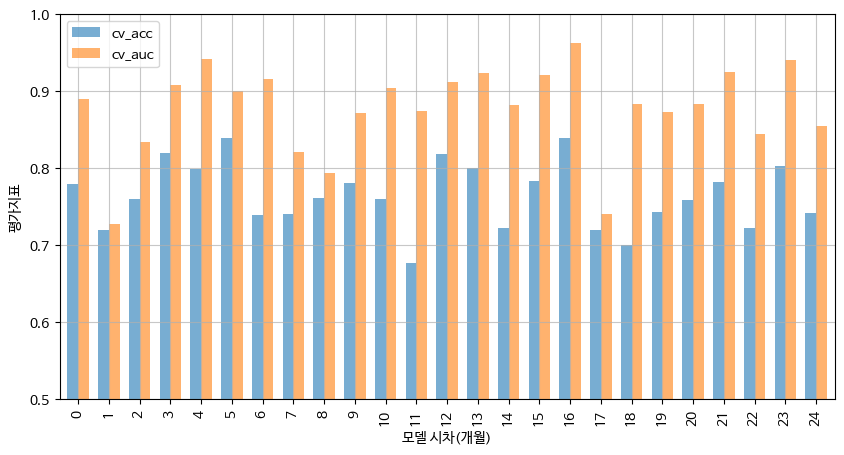

In [513]:
# 그래프

temp = result.set_index("lag").iloc[:, :]
temp.index = temp.index * -1

# fig, ax1 = plt.subplots(figsize=(10, 5))
# ax2 = ax1.twinx()
# ax1.bar(temp.index, temp["cv_acc"], width=0.7, alpha=0.8, color="#5b93c4")
# ax1.set_ylim(0.3, 0.9)
# ax2.plot(temp.index, temp["cv_auc"], alpha=0.8, color="#f59639", marker=".")
# ax2.set_ylim(0.2, 1)


temp[["cv_acc", "cv_auc"]].plot.bar(figsize=(10, 5), width=0.7, alpha=0.6)

# ax1.bar(x, y1, color = 'gray', alpha=0.5)
# ax1.set_xlabel('기간')
# ax1.set_ylabel('기성총액(100만원)')

# ax2 = ax1.twinx()
# ax2.plot(x, y2, color='blue', alpha=0.5)
# ax2.plot(x, trend, color='red', linewidth=1.5, label="Trend", alpha=0.9, linestyle="--")
# ax2.set_ylabel('기성총액 YoY')

# temp[["cv_acc", "cv_auc"]].plot.bar(figsize=(10, 5), width=0.7, alpha=0.8)
# # temp[["cv_acc"]].plot.bar(figsize=(10, 5), width=0.7, alpha=0.8)
# temp["cv_acc_std"].plot.bar(alpha=0.5, color="green")
plt.xlabel("모델 시차(개월)")
plt.ylabel("평가지표")
plt.ylim(0.5, 1)
plt.grid(alpha=0.7)
plt.savefig(f"./result_cv{k}_bt{bootstrap_size}.png")
plt.show()

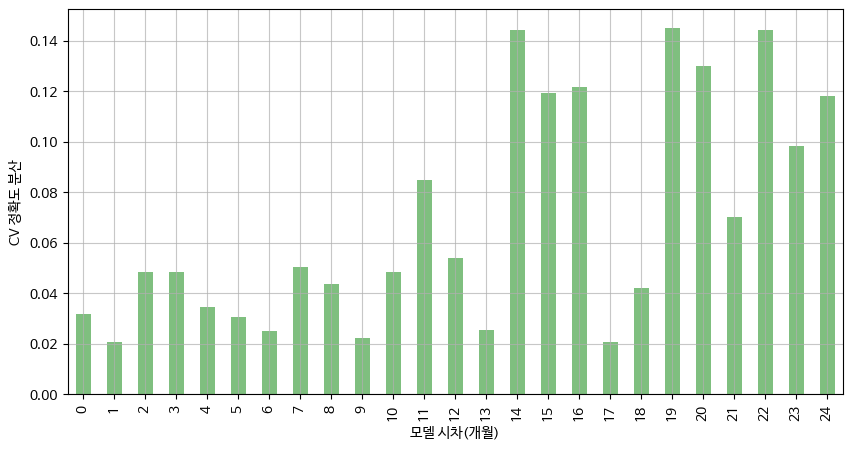

In [515]:
temp["cv_acc_std"].plot.bar(alpha=0.5, color="green", figsize=(10, 5))
plt.grid(alpha=0.7)
plt.xlabel("모델 시차(개월)")
plt.ylabel("CV 정확도 분산")
plt.savefig(f"./result_cv{k}_bt{bootstrap_size}_std.png")
plt.show()

In [40]:
## TODO
# 1. 부트스트래핑 없이도 돌려보기
# 2. 라고 예약 확인 전화하기

### 지정한 lag으로 예측값 생성하기

- 전체 데이터에 대해 fit 하고, 전체 데이터에 대해 proba 값 뽑음

In [396]:
# 데이터 준비
lag = 16
temp = data.copy()
temp["yoy_bin"] = temp["yoy_bin"].shift(-lag)
temp = temp.dropna()
X = temp.drop("yoy_bin", axis=1)
y = temp["yoy_bin"]
# temp

In [397]:
# predict용 최신에서 lag+1개 만큼의 데이터
temp = data.copy()
temp = temp.iloc[-(lag + 1):, :]
X_to_pred = temp.drop("yoy_bin", axis=1)
y_to_pred = temp["yoy_bin"]
# temp

In [398]:
# fit
model = RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=1)
model.fit(X, y)

RandomForestClassifier(n_jobs=1, random_state=1)

In [399]:
# predict (일부 기간)
y_pred = model.predict(X_to_pred)
y_pred_proba = model.predict_proba(X_to_pred)

# acc = accuracy_score(y_to_pred, y_pred)
# vc = y_test.value_counts()
# if len(vc.index) == 2:  # 0과 1 모두 y에 존재하는 경우
#     auc = roc_auc_score(y_to_pred, y_pred_proba[:, 1])
# else:  # else: ROC_AUC 계산 불가함
#     auc = None
# acc, auc

Text(0.5, 0, 'Start From 2023.05')

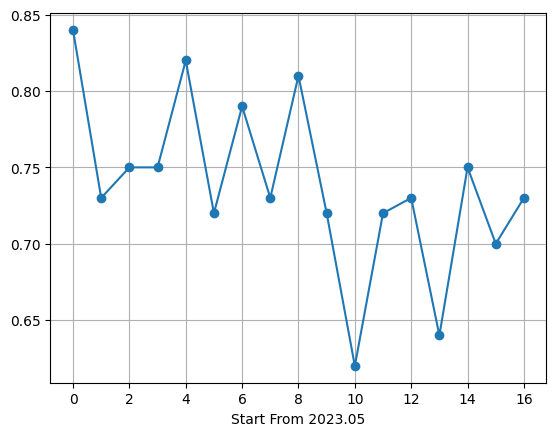

In [400]:
# predict proba 값들 반환
# ym = y_to_pred.index.astype(int) + 100
# pd.Series(y_pred_proba[:, 1], index=ym.astype(str)).plot(marker="o")
pd.Series(y_pred_proba[:, 1]).plot(marker="o")
# pd.Series(y_pred_proba[:, 1]).plot.bar(alpha=0.6)
plt.grid()
# plt.ylim(0.5, 1)
plt.xlabel("Start From 2023.05")

In [405]:
lags = [3, 5, 12, 16]

probas = []
for lag in tqdm(lags):
    temp = data.copy()
    temp["yoy_bin"] = temp["yoy_bin"].shift(-lag)
    temp = temp.dropna()
    X = temp.drop("yoy_bin", axis=1)
    y = temp["yoy_bin"]
    
    temp = data.copy()
    temp = temp.iloc[-(lag + 1):, :]
    X_to_pred = temp.drop("yoy_bin", axis=1)
    y_to_pred = temp["yoy_bin"]
    
    # fit
    model = RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=1)
    model.fit(X, y)
    
    # predict (일부 기간)
    y_pred = model.predict(X_to_pred)
    y_pred_proba = model.predict_proba(X_to_pred)
    probas.append(y_pred_proba[:, 1])

100%|██████████| 4/4 [00:14<00:00,  3.54s/it]


In [418]:
temp

,것,등,수,시장,투자,경제,기업,올해,전망,미국,...,스피룰리나,게임광,죠슈,글쎼잇단,공을기,우웨,증열,트파이낸싱,물량만해,yoy_bin
ym,,,,,,,,,,,,,,,,,,,,,
202201,121.133666,108.436852,76.652609,46.308365,40.796647,20.954461,40.945612,32.082173,22.051839,24.822595,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
202202,112.604197,110.624783,75.536518,48.758826,39.336222,17.570080,34.354326,22.173886,18.192817,23.196954,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
202203,115.616306,115.947111,73.212634,47.222397,32.209369,22.571920,33.753125,28.173549,17.179800,19.942021,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
202204,123.217349,108.879972,79.608083,45.869855,33.866187,25.877959,33.671203,21.472552,19.199776,19.589743,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
202205,115.255699,117.958195,74.833920,46.941420,58.277185,22.445444,35.658234,24.906083,16.840655,34.243892,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
202206,114.832174,117.170647,75.288328,44.247067,38.450806,24.751031,33.174790,24.787816,18.613196,22.517658,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
202207,117.678122,113.798135,76.282327,47.010103,43.824956,26.492864,38.788755,25.592351,20.539474,25.247711,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
202208,113.143838,122.210739,77.300712,43.172487,41.231197,21.897529,33.732043,26.521536,18.343213,29.504218,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
202209,112.860599,113.467472,80.815305,48.734312,40.077442,20.645594,33.854015,22.555460,17.468434,31.753757,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0


In [544]:
prob_df = pd.DataFrame(probas).T
prob_df.columns = lags
dates = pd.date_range(start="2023-05-01", periods=max(lags) + 1, freq="M").to_period("M")
# prob_df.index = dates.strftime("%Y.%m")
prob_df.index = dates.astype(str).str.replace("-", ".")
prob_df = prob_df.loc[:, [3, 5, 12]]
prob_df.columns = ["3M Lag Model", "5M Lag Model", "12M Lag Model"]
prob_df

,3M Lag Model,5M Lag Model,12M Lag Model
2023.05,0.82,0.84,0.75
2023.06,0.86,0.87,0.80
2023.07,0.76,0.82,0.85
2023.08,0.77,0.79,0.84
2023.09,NaN,0.82,0.79
2023.10,NaN,0.83,0.79
2023.11,NaN,NaN,0.81
2023.12,NaN,NaN,0.85
2024.01,NaN,NaN,0.72
2024.02,NaN,NaN,0.75


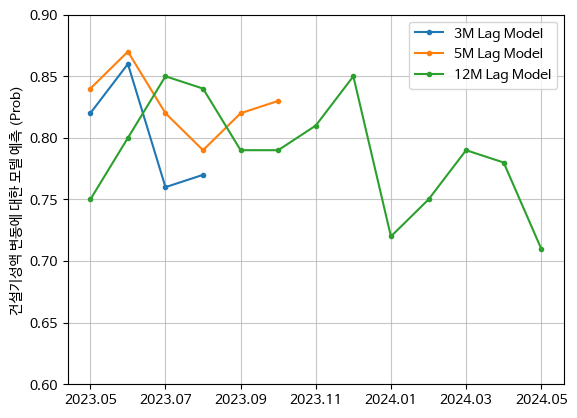

In [545]:
prob_df.plot(marker=".")
# prob_df.plot.bar(width=1, alpha=0.8)
plt.ylabel("건설기성액 변동에 대한 모델 예측 (Prob)")
plt.ylim(0.60, 0.90)
plt.grid(alpha=0.7)
plt.savefig("./모델 예측_202305.png", dpi=300)
plt.show()

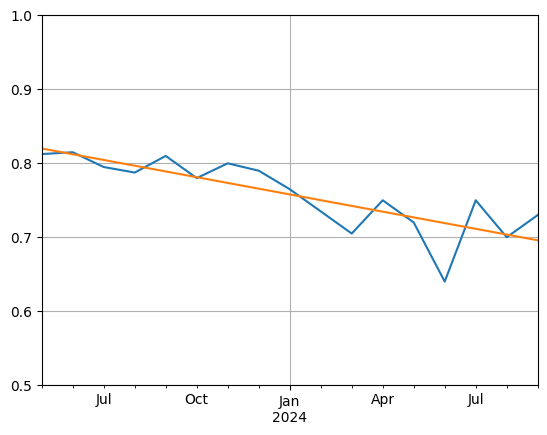

In [424]:
prob_df.mean(axis=1).plot()
cycle, trend = sm.tsa.filters.hpfilter(prob_df.mean(axis=1), 14400)
plt.ylim(0.5, 1)
plt.grid()

In [404]:
len(dates)

17

In [459]:
# 전체 기간 pred한 것 저장
# lags = [5, 12, 16]
print("lags:", lags)

preds = []
for lag in tqdm(lags[:]):
    temp = data.copy()
    temp["yoy_bin"] = temp["yoy_bin"].shift(-lag)
    temp = temp.dropna()
    # temp = temp.iloc[-12:, ].copy()  # 12개의 데이터를 추가로 없앰
    
    # 16개의 데이터를 없앰 (21년 12월까지로 fit, 23년 4월에서 > 21년 12월까지만 빼는 것)
    X = temp.drop("yoy_bin", axis=1).iloc[:-16, :]
    y = temp["yoy_bin"].iloc[:-16]
    # X = temp.drop("yoy_bin", axis=1)
    # y = temp["yoy_bin"]
    
    # fit
    model = RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=1)
    model.fit(X, y)
    
    # predict
    y_pred_proba = model.predict_proba(data.drop("yoy_bin", axis=1))
    y_pred_proba = y_pred_proba[:, 1]
    
    # 2017-01-01부터 생성하고, 뒤에 lag 개수만큼 추가하고 앞에서 lag 개수만큼 제거
    dates = pd.date_range(start="2017-01-01", periods=len(data) + lag, freq="M")[lag:]
    pred = pd.Series(y_pred_proba, index=dates)
    preds.append(pred)

lags: [3, 5, 12, 16]


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


In [468]:
df = pd.DataFrame(preds).T
df.columns = lags
# df.to_csv("lag_model_fit_predict_probas_202201.csv")
df

,3,5,12,16
2017-04-30,0.86,NaN,NaN,NaN
2017-05-31,0.92,NaN,NaN,NaN
2017-06-30,0.93,0.83,NaN,NaN
2017-07-31,0.93,0.93,NaN,NaN
2017-08-31,0.92,0.91,NaN,NaN
...,...,...,...,...
2024-05-31,NaN,NaN,0.47,0.47
2024-06-30,NaN,NaN,NaN,0.54
2024-07-31,NaN,NaN,NaN,0.50
2024-08-31,NaN,NaN,NaN,0.42


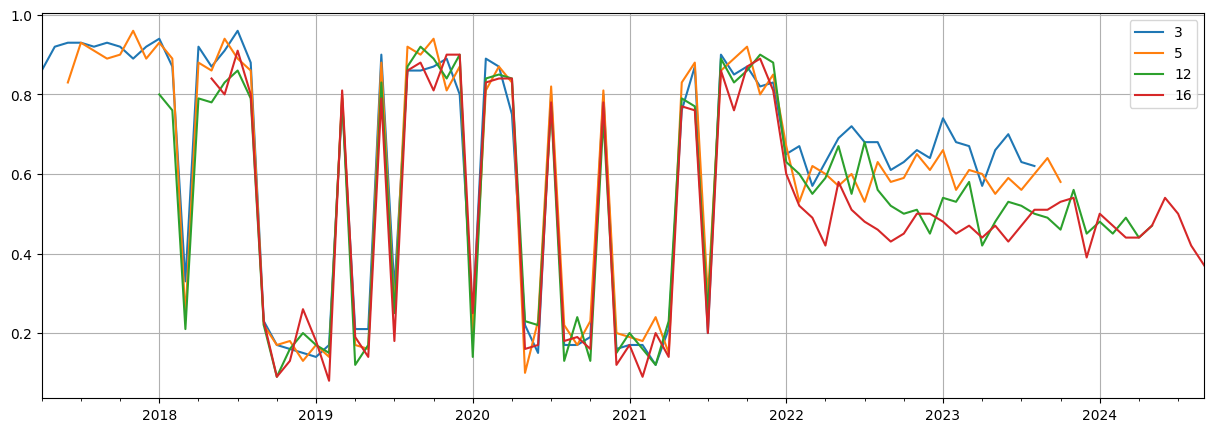

In [461]:
df.plot(figsize=(15, 5))
plt.grid()

In [466]:
# 정확도 구하기 위한 데이터
temp = df.copy()
temp.index = temp.index.strftime("%Y%m")
temp = pd.merge(temp, target[["yoy", "yoy_bin"]], how="left", left_index=True, right_index=True)
temp = temp.iloc[-1*(max(lags) + 17):, :]
temp

,3,5,12,16,yoy,yoy_bin
202201,0.65,0.67,0.63,0.60,0.188205,1.0
202202,0.67,0.53,0.60,0.52,0.060351,1.0
202203,0.57,0.62,0.55,0.49,0.079570,1.0
202204,0.63,0.60,0.59,0.42,0.091877,1.0
202205,0.69,0.57,0.67,0.58,0.164260,1.0
202206,0.72,0.60,0.55,0.51,0.150492,1.0
202207,0.68,0.53,0.68,0.48,0.123357,1.0
202208,0.68,0.63,0.56,0.46,0.127174,1.0
202209,0.61,0.58,0.52,0.43,0.118175,1.0
202210,0.63,0.59,0.50,0.45,0.150175,1.0


<Axes: >

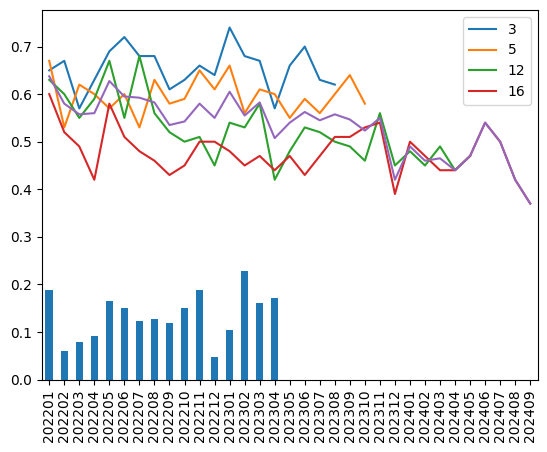

In [470]:
temp[lags].plot()
temp[lags].mean(axis=1).plot()
temp["yoy"].plot.bar()

In [435]:
# 정확도 계산
func = lambda x: 0 if x < 0.5 else 1
lag_col = 5
tmp = temp[[lag_col, "yoy_bin"]].copy().dropna()
acc = accuracy_score(tmp["yoy_bin"], tmp[lag_col].apply(func))
auc = roc_auc_score(tmp["yoy_bin"], tmp[lag_col])
acc, auc, tmp["yoy_bin"].mean()

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [ ]:
temp[lag_col]

In [263]:
yms

DatetimeIndex(['2017-06-30', '2017-07-31', '2017-08-31', '2017-09-30',
               '2017-10-31', '2017-11-30', '2017-12-31', '2018-01-31',
               '2018-02-28', '2018-03-31', '2018-04-30', '2018-05-31',
               '2018-06-30', '2018-07-31', '2018-08-31', '2018-09-30',
               '2018-10-31', '2018-11-30', '2018-12-31', '2019-01-31',
               '2019-02-28', '2019-03-31', '2019-04-30', '2019-05-31',
               '2019-06-30', '2019-07-31', '2019-08-31', '2019-09-30',
               '2019-10-31', '2019-11-30', '2019-12-31', '2020-01-31',
               '2020-02-29', '2020-03-31', '2020-04-30', '2020-05-31',
               '2020-06-30', '2020-07-31', '2020-08-31', '2020-09-30',
               '2020-10-31', '2020-11-30', '2020-12-31', '2021-01-31',
               '2021-02-28', '2021-03-31', '2021-04-30', '2021-05-31',
               '2021-06-30', '2021-07-31', '2021-08-31', '2021-09-30',
               '2021-10-31', '2021-11-30', '2021-12-31', '2022-01-31',
      

In [207]:
# predict (전체 기간)
temp = data.copy()
X_all = temp.drop("yoy_bin", axis=1)

y_pred = model.predict(X_all)
y_pred_proba = model.predict_proba(X_all)
temp["yoy_bin"] = temp["yoy_bin"].shift(-lag)
# temp = temp.dropna()

pred = pd.DataFrame([y_pred, y_pred_proba[:, 1]]).T
pred.index = X_all.index
pred.columns = ["Predict", "Proba"]
pred

,Predict,Proba
ym,,
201701,1.0,0.81
201702,1.0,0.81
201703,1.0,0.78
201704,1.0,0.78
201705,0.0,0.19
...,...,...
202301,1.0,0.73
202302,1.0,0.64
202303,1.0,0.75


<Axes: xlabel='ym'>

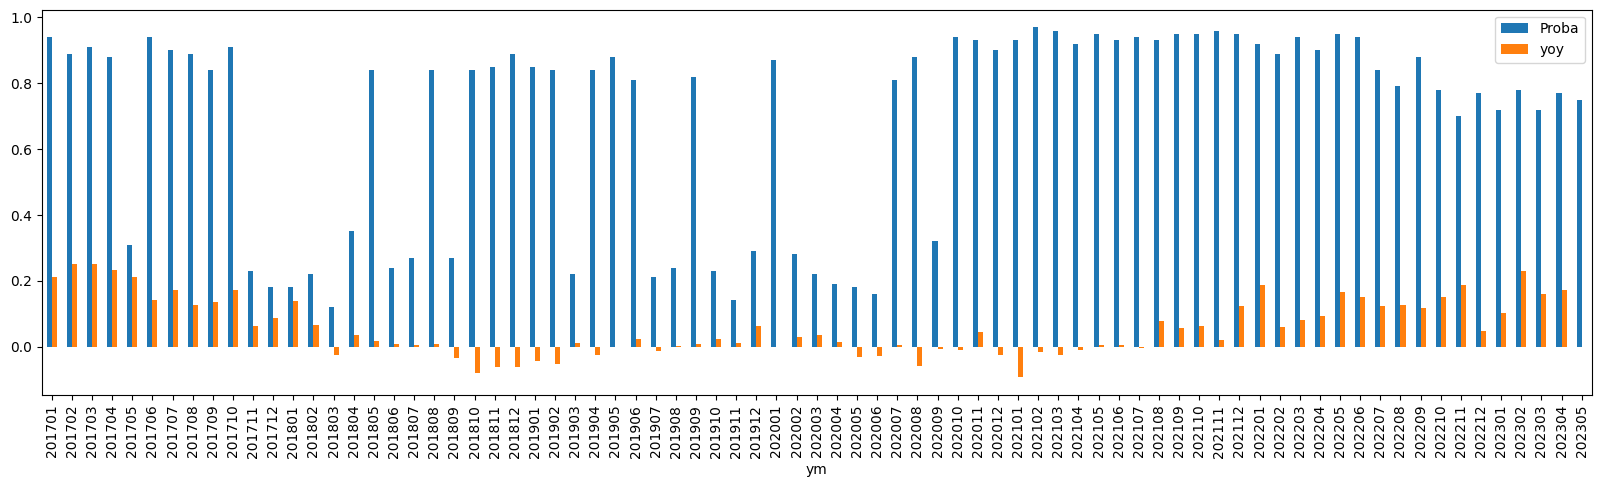

In [152]:
merged = pd.merge(pred, target, how="left", left_index=True, right_index=True)
merged[["Proba", "yoy"]].plot.bar(figsize=(20, 5))
# merged[["Predict", "yoy"]].plot.bar(figsize=(20, 5))
# merged[["Proba", "yoy"]].plot.bar(figsize=(20, 5))
# merged